In [1]:
#Libraries/functions import
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib
from pylab import rcParams
rcParams['figure.figsize'] = 16, 10
import pyproj
import matplotlib.image as image
from lxml import etree
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from matplotlib.collections import PatchCollection
from mpl_toolkits.basemap import Basemap
from shapely.geometry import Point, Polygon, MultiPoint, MultiPolygon
from shapely.prepared import prep
from pysal.esda.mapclassify import Natural_Breaks as nb
from descartes import PolygonPatch
import fiona
from itertools import chain
from matplotlib import colors
import datetime
from pandas.io.json import json_normalize
import requests
import facebook
import matplotlib.ticker as plticker

In [2]:
# Convenience functions for working with colour ramps and bars
def colorbar_index(ncolors, cmap, labels=None, **kwargs):
    """
    This is a convenience function to stop you making off-by-one errors
    Takes a standard colour ramp, and discretizes it,
    then draws a colour bar with correctly aligned labels
    """
    cmap = cmap_discretize(cmap, ncolors)
    mappable = cm.ScalarMappable(cmap=cmap)
    mappable.set_array([])
    mappable.set_clim(-0.5, ncolors+0.5)
    colorbar = plt.colorbar(mappable, **kwargs)
    colorbar.set_ticks(np.linspace(0, ncolors, ncolors))
    colorbar.set_ticklabels(range(ncolors))
    if labels:
        colorbar.set_ticklabels(labels)
    return colorbar

def cmap_discretize(cmap, N):
    """
    Return a discrete colormap from the continuous colormap cmap.

        cmap: colormap instance, eg. cm.jet. 
        N: number of colors.

    Example
        x = resize(arange(100), (5,100))
        djet = cmap_discretize(cm.jet, 5)
        imshow(x, cmap=djet)

    """
    if type(cmap) == str:
        cmap = get_cmap(cmap)
    colors_i = np.concatenate((np.linspace(0, 1., N), (0., 0., 0., 0.)))
    colors_rgba = cmap(colors_i)
    indices = np.linspace(0, 1., N + 1)
    cdict = {}
    for ki, key in enumerate(('red', 'green', 'blue')):
        cdict[key] = [(indices[i], colors_rgba[i - 1, ki], colors_rgba[i, ki]) for i in xrange(N + 1)]
    return matplotlib.colors.LinearSegmentedColormap(cmap.name + "_%d" % N, cdict, 1024)

In [78]:
#Dates used in file names, maps etc.
current_time = datetime.datetime.now().strftime("%d-%m-%Y %H:%M")
the_day = datetime.date.today() + datetime.timedelta(days=-1)
date_to_print = the_day.strftime("%d-%m-%Y")
date_to_file = the_day.strftime("%d%m%y")
current_time_to_file = datetime.datetime.now().strftime("%Y%m%d%H%M")

In [63]:
#airly apikey
airly = '***'

#facebook token
token = "***"

In [64]:
#Fetching data about sensors' location, names, id, current air pollution etc.

headers = {
    'Accept': 'application/json',
    'apikey': airly,
}

#rybnik's geographical coordinates
params = (
    ('southwestLat', '50.033'),
    ('southwestLong', '18.428'),
    ('northeastLat', '50.180'),
    ('northeastLong', '18.662'),
)

response = requests.get('https://airapi.airly.eu/v1/sensors/current', headers=headers, params=params)

#transform response to json
data_js = response.json()

#only official rybnik's sensors
df_temp = pd.DataFrame.from_records(data_js).query("name == 'Rybnik' and vendor == 'Airly'")

#unfold address dict
df_temp = pd.concat([df_temp.drop(['address'], axis=1), df_temp['address'].apply(pd.Series)], axis=1)

#unfold location dict
sensors = pd.concat([df_temp.drop(['location'], axis=1), df_temp['location'].apply(pd.Series)], axis=1).reset_index(drop=True)

#set sensor's id as index
sensors.set_index('id',inplace=True)

In [65]:
#Fetch more detailed data, 24h history - one query per one sensor

#if pollutionLevel == 0 - sensor doesnt work, lets exclude it
ids = list(sensors.query('pollutionLevel != 0').index)


headers = {
    'Accept': 'application/json',
    'apikey': airly,
}

allData = []
currentMeasure = []

for i, sensId in enumerate(ids):
    
    params = (
        ('sensorId', str(sensId)),
    )

    response = requests.get('https://airapi.airly.eu/v1/sensor/measurements', headers=headers, params=params)
    data_js = response.json()
    allData.append(pd.DataFrame.from_dict(json_normalize(data_js), orient='columns'))
        
    currentMeasure.append(allData[i].iloc[:,:-2])
    currentMeasure[i]['id'] = sensId
    
    #weather data for sensor in city center
    if sensId == 2107:
        weather = allData[-1].copy()
    

In [75]:
weather['currentMeasurements.pressure']

0    101123.87889
Name: currentMeasurements.pressure, dtype: float64

In [66]:
weatherData = pd.pivot_table(pd.DataFrame.from_dict(weather.history[0][0]).reset_index(), index=['fromDateTime', 'tillDateTime'], columns = 'index', values='measurements')
for i in range(len(weather.history[0])-1):
        weatherData = pd.concat([weatherData, pd.pivot_table(pd.DataFrame.from_dict(weather.history[0][i+1]).reset_index(), index=['fromDateTime', 'tillDateTime'], columns = 'index', values='measurements')])

weatherData.reset_index(inplace=True)
weatherData['hours'] = weatherData.fromDateTime.apply(lambda x: x[11:-4])

#Pa to hPa
weatherData.pressure = weatherData.pressure/100

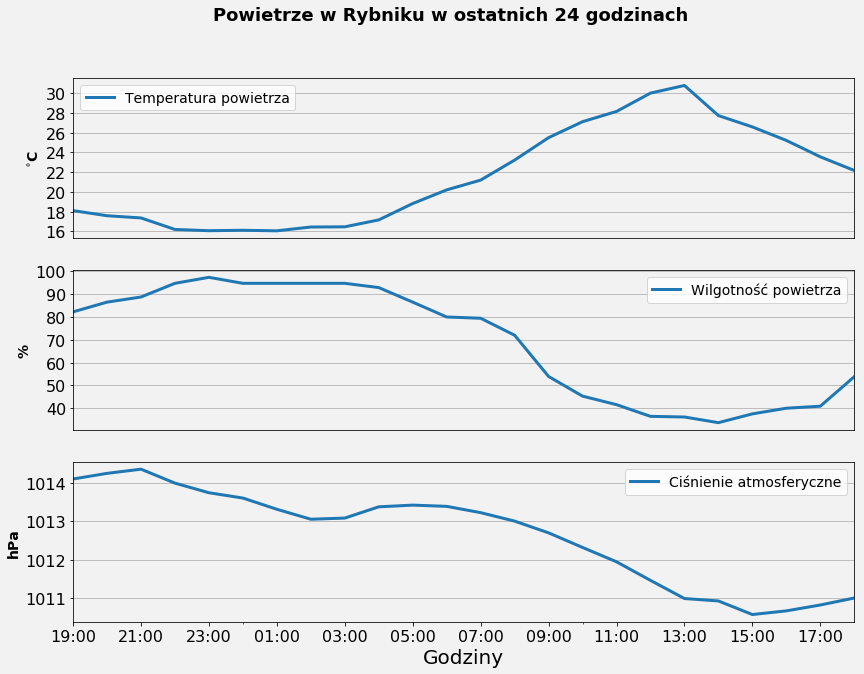

In [67]:
rcParams['figure.figsize'] = 14, 10

plt.figure()
f, axes = plt.subplots(3, 1, sharex=True)
f.patch.set_facecolor('#f2f2f2')
plt.suptitle('Powietrze w Rybniku w ostatnich 24 godzinach', fontsize=18, weight='bold')

axes[0].patch.set_facecolor('#f2f2f2')
axes[1].patch.set_facecolor('#f2f2f2')
axes[2].patch.set_facecolor('#f2f2f2')


#plt.sub.t
weatherData.plot(ax=axes[0], x='hours', y='temperature', label='Temperatura powietrza', linewidth=3)
axes[0].set_ylabel('$^{\circ}$C', fontsize=14, weight='bold')
axes[0].xaxis.grid(True)
axes[0].yaxis.grid(True)
axes[0].axes.get_xaxis().set_visible(False)    

loc = plticker.MultipleLocator(base=2.) # this locator puts ticks at regular intervals
axes[0].yaxis.set_major_locator(loc)
axes[0].yaxis.set_tick_params(labelsize=16)
axes[0].legend(prop={'size': 14})

weatherData.plot(ax=axes[1],  x='hours', y='humidity', label='Wilgotność powietrza', linewidth=3)
axes[1].set_ylabel('%', fontsize=14, weight='bold')
axes[1].xaxis.grid(True)
axes[1].yaxis.grid(True)
axes[1].axes.get_xaxis().set_visible(False)   
loc = plticker.MultipleLocator(base=10.0) # this locator puts ticks at regular intervals
axes[1].yaxis.set_major_locator(loc)
axes[1].yaxis.set_tick_params(labelsize=16)
axes[1].legend(prop={'size': 14})


weatherData.plot(ax=axes[2],  x='hours', y='pressure', label='Ciśnienie atmosferyczne', linewidth=3)
axes[2].set_ylabel('hPa', fontsize=14, weight='bold')

axes[2].yaxis.grid(True)
axes[2].axes.get_xaxis().set_visible(True)

loc = plticker.MultipleLocator(base=1.) # this locator puts ticks at regular intervals
axes[2].yaxis.set_major_locator(loc)
axes[2].yaxis.set_tick_params(labelsize=16)



axes[2].xaxis.label.set_fontsize(20) 
axes[2].set_xticks(weatherData.index[::2].values)
axes[2].set_xticklabels(weatherData.hours[::2].values, fontsize = 16)
axes[2].legend(prop={'size': 14})
axes[2].set_xlabel('Godziny')


plt.savefig('pictures/weather_%s.png'%current_time_to_file, dpi=200, alpha=True, bbox_inches='tight')
plt.show()

In [68]:
#Data about current air quality can be found in currentData df

currentData = pd.concat(currentMeasure)
currentData.set_index('id',inplace=True)


#Data about maximum values in each district within last 24h can be found hist_max df
hist_max = pd.DataFrame(columns=['airQualityIndex','humidity','pm1','pm10', 'pm25', 'pollutionLevel','pressure', 'temperature'])
for j in range(len(allData)):
    history = pd.pivot_table(pd.DataFrame.from_dict(allData[j].history[0][0]).reset_index(), index=['fromDateTime', 'tillDateTime'], columns = 'index', values='measurements')
    for i in range(len(allData[j].history[0])-1):
        history = pd.concat([history, pd.pivot_table(pd.DataFrame.from_dict(allData[j].history[0][i+1]).reset_index(), index=['fromDateTime', 'tillDateTime'], columns = 'index', values='measurements')])
    hist_max = pd.concat([hist_max, history.max(axis=0,level=None).to_frame().T])
    
hist_max['id'] = ids
hist_max.set_index('id', inplace=True)

In [69]:
#Map creation

shp = fiona.open('data/city.shp')
bds = shp.bounds
shp.close()
extra = 0.01
ll = (bds[0], bds[1])
ur = (bds[2], bds[3])
coords = list(chain(ll, ur))
w, h = coords[2] - coords[0], coords[3] - coords[1]

m = Basemap(
    projection='tmerc',
    lon_0=18,
    lat_0=50.,
    ellps = 'WGS84',
    llcrnrlon=coords[0] - 2*extra * w,
    llcrnrlat=coords[1] - 2*extra + 0.01 * h,
    urcrnrlon=coords[2] + extra * w,
    urcrnrlat=coords[3] + extra + 0.01 * h,
    lat_ts=0,
    resolution='i',
    suppress_ticks=True)
m.readshapefile(
    'data/city',
    'rybnik',
    color='none',
    zorder=2)

(27,
 5,
 [18.44168423057649, 50.03540818733495, 0.0, 0.0],
 [18.656839587997112, 50.18567083284379, 0.0, 0.0],
 <matplotlib.collections.LineCollection at 0x1967e320>)

In [70]:
#Map dataframe set up
df_map = pd.DataFrame({
    'poly': [Polygon(xy) for xy in m.rybnik],
    'district': [ward['name'] for ward in m.rybnik_info],
    'id': [ward['id'] for ward in m.rybnik_info]})

df_map = df_map.sort_values('district')
df_map.set_index('id',inplace=True)

#It contains current and history data for every sensor
df_map = df_map.join(sensors, how='inner', lsuffix='sens').join(hist_max, how='inner', rsuffix='hist').join(currentData, how='inner', rsuffix='current')

df_map = df_map.reset_index()

In [71]:
#Create Point objects in map coordinates from dataframe lon and lat values

map_points = pd.Series(
    [Point(m(mapped_x, mapped_y)) for mapped_x, mapped_y in zip(sensors['longitude'], sensors['latitude'])])
plaque_points = MultiPoint(list(map_points.values))
wards_polygon = prep(MultiPolygon(list(df_map['poly'].values)))
# calculate points that fall within the London boundary
ldn_points = filter(wards_polygon.contains, plaque_points)

df_map['count'] = df_map['poly'].map(lambda x: int(len(filter(prep(x).contains, ldn_points))))

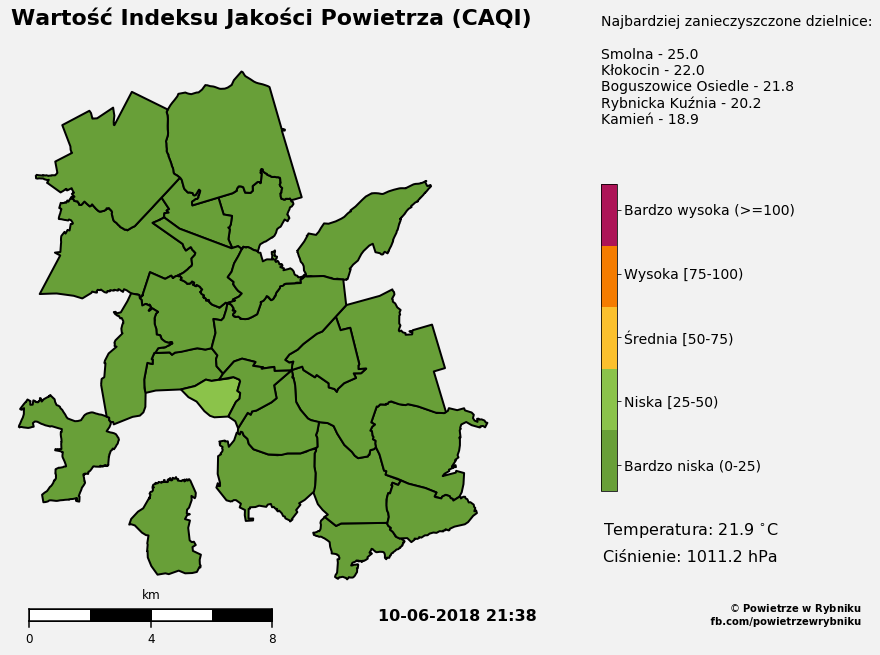

In [79]:
#Create a map with current measurements for Common Air Quality Index

caqi_labels = ['Bardzo niska (0-25)',
 'Niska [25-50)',
 'Średnia [50-75)',
 'Wysoka [75-100)',
    'Bardzo wysoka (>=100)']

for i, text in enumerate(caqi_labels):
    caqi_labels[i] = text.decode('utf-8')
    

cmap = colors.ListedColormap(['#689f38','#8bc34a','#fbc02d','#f57c00','#ad1457'])#,'#8e3ac4', '#b10000'])
bounds= [1,2,3,4,5,6]
norm = colors.BoundaryNorm(bounds, cmap.N)


plt.clf()
fig = plt.figure()
ax = fig.add_subplot(111, facecolor='w', frame_on=False)
fig.patch.set_facecolor('#f2f2f2')

# draw wards with black outlines
df_map['patches'] = df_map['poly'].map(lambda x: PolygonPatch(x, ec='#000000', lw=2., alpha=1., zorder=4))
pc = PatchCollection(df_map['patches'], match_original=True)
# impose our colour map onto the patch collection

pc.set_facecolor(cmap(norm(df_map['pollutionLevel'].values)))
ax.add_collection(pc)


# Add a colour bar
cb = colorbar_index(ncolors=len(caqi_labels), cmap=cmap, shrink=0.5, labels=caqi_labels)
cb.ax.tick_params(labelsize=14)


# Show highest pollutions, in descending order
highest = '\n'.join(
    value[1] + " - " + str(round(value['currentMeasurements.airQualityIndex'],1)) 
    for _, value in df_map.sort_values(by='currentMeasurements.airQualityIndex', ascending=False)[:5].iterrows()).decode('utf-8')

highest = 'Najbardziej zanieczyszczone dzielnice:\n\n' + highest
# Subtraction is necessary for precise y coordinate alignment
details = cb.ax.text(
    0., 1.55,
    highest,
    ha='left', va='top',
    size=14,
    color='#000000')

# Show current date-hour
date = ax.text(
    1.10, 0.033,
    current_time,
    ha='right', va='bottom',  weight = 'bold',
    size=16,
    color='#000000',
transform=ax.transAxes)

# Show current temperature
tmpr = ax.text(
    1.24, 0.170,
    "Temperatura: %s $^{\circ}$C" %round(weather['currentMeasurements.temperature'].values[-1],1),
    ha='left', va='bottom', 
    size=16,
    color='#000000',
transform=ax.transAxes)

# Show current pressure
prsr = ax.text(
    1.24, 0.130,
    u"Ciśnienie: %s hPa" %round(weather['currentMeasurements.pressure'].values[-1]/100,1),
    ha='left', va='bottom', 
    size=16,
    color='#000000',
transform=ax.transAxes)

# Bin method, copyright and source data info
smallprint = cb.ax.text(
    1.78, 0.028,
    '$\copyright$ Powietrze w Rybniku\n fb.com/powietrzewrybniku'.decode('utf-8'),
    ha='right', va='bottom',
    size=10,
    weight = 'bold',
    color='#000000',
    transform=ax.transAxes)


# Draw a map scale
m.drawmapscale(
    coords[0] + 0.06, coords[1] - 0.01,
    coords[0], coords[1], 
    8.,
    barstyle='fancy', labelstyle='simple',
    fillcolor1='w', fillcolor2='#000000',
    fontcolor='#000000', fontsize=12,
    zorder=5)


#Title
plt.title("Wartość Indeksu Jakości Powietrza (CAQI)".decode('utf-8'), fontsize=22, loc='left', weight='bold')


#Save the file
plt.tight_layout()
plt.gcf().subplots_adjust(bottom=0.1)
fig.set_size_inches(12, 10)
plt.savefig('pictures/cur_caqi_%s.png'%current_time_to_file, dpi=200, alpha=True, bbox_inches='tight')
plt.show()

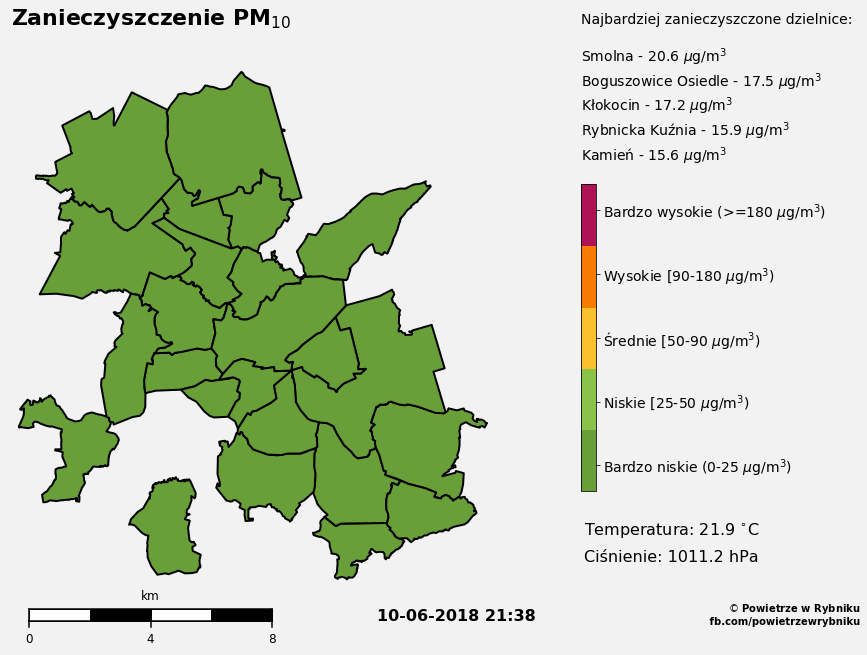

In [80]:
#Create a map with current measurements for PM10 Index


pm10_labels = ['Bardzo niskie (0-25 $\mu$g/m$^3$)',
 'Niskie [25-50 $\mu$g/m$^3$)',
 'Średnie [50-90 $\mu$g/m$^3$)',
 'Wysokie [90-180 $\mu$g/m$^3$)',
    'Bardzo wysokie (>=180 $\mu$g/m$^3$)']

for i, text in enumerate(pm10_labels):
    pm10_labels[i] = text.decode('utf-8')
    
cmap = colors.ListedColormap(['#689f38','#8bc34a','#fbc02d','#f57c00','#ad1457'])
bounds= [0,25,50,90,180,1000]
norm = colors.BoundaryNorm(bounds, cmap.N)


plt.clf()
fig = plt.figure()
ax = fig.add_subplot(111, facecolor='w', frame_on=False)
fig.patch.set_facecolor('#f2f2f2')


# draw wards with black outlines
df_map['patches'] = df_map['poly'].map(lambda x: PolygonPatch(x, ec='#000000', lw=2., alpha=1., zorder=4))
pc = PatchCollection(df_map['patches'], match_original=True)

pc.set_facecolor(cmap(norm(df_map['currentMeasurements.pm10'].values)))
ax.add_collection(pc)


# Add a colour bar
cb = colorbar_index(ncolors=len(pm10_labels), cmap=cmap, shrink=0.5, labels=pm10_labels)
cb.ax.tick_params(labelsize=14)


# Show highest densities, in descending order
highest = '\n'.join(
    value[1] + " - " + str(round(value['currentMeasurements.pm10'],1)) + " $\mu$g/m$^3$" for _, value in df_map.sort_values(by='currentMeasurements.pm10', ascending=False)[:5].iterrows()).decode('utf-8')


highest = 'Najbardziej zanieczyszczone dzielnice:\n\n' + highest
# Subtraction is necessary for precise y coordinate alignment
details = cb.ax.text(
    0., 1.55,
    highest,
    ha='left', va='top',
    size=14,
    color='#000000')

# Show current date-hour
date = ax.text(
    1.10, 0.033,
    current_time,
    ha='right', va='bottom',  weight = 'bold',
    size=16,
    color='#000000',
transform=ax.transAxes)


# Show current temperature
tmpr = ax.text(
    1.2, 0.170,
    "Temperatura: %s $^{\circ}$C" %round(weather['currentMeasurements.temperature'].values[-1],1),
    ha='left', va='bottom', 
    size=16,
    color='#000000',
transform=ax.transAxes)

# Show current pressure
prsr = ax.text(
    1.2, 0.130,
    u"Ciśnienie: %s hPa" %round(weather['currentMeasurements.pressure'].values[-1]/100,1),
    ha='left', va='bottom', 
    size=16,
    color='#000000',
transform=ax.transAxes)

# Bin method, copyright and source data info
smallprint = cb.ax.text(
    1.78, 0.028,
    '$\copyright$ Powietrze w Rybniku\n fb.com/powietrzewrybniku'.decode('utf-8'),
    ha='right', va='bottom',
    size=10,
    weight = 'bold',
    color='#000000',
    transform=ax.transAxes)


# Draw a map scale
m.drawmapscale(
    coords[0] + 0.06, coords[1] - 0.01,
    coords[0], coords[1], 
    8.,
    barstyle='fancy', labelstyle='simple',
    fillcolor1='w', fillcolor2='#000000',
    fontcolor='#000000', fontsize=12,
    zorder=5)

#Title
plt.title("Zanieczyszczenie PM$_{10}$".decode('utf-8'), fontsize=22, loc='left', weight='bold')


#Save the file
plt.tight_layout()
plt.gcf().subplots_adjust(bottom=0.1)
fig.set_size_inches(12, 10)
plt.savefig('pictures/cur_pm10_%s.png'%current_time_to_file, dpi=200, alpha=True, bbox_inches='tight')
plt.show()

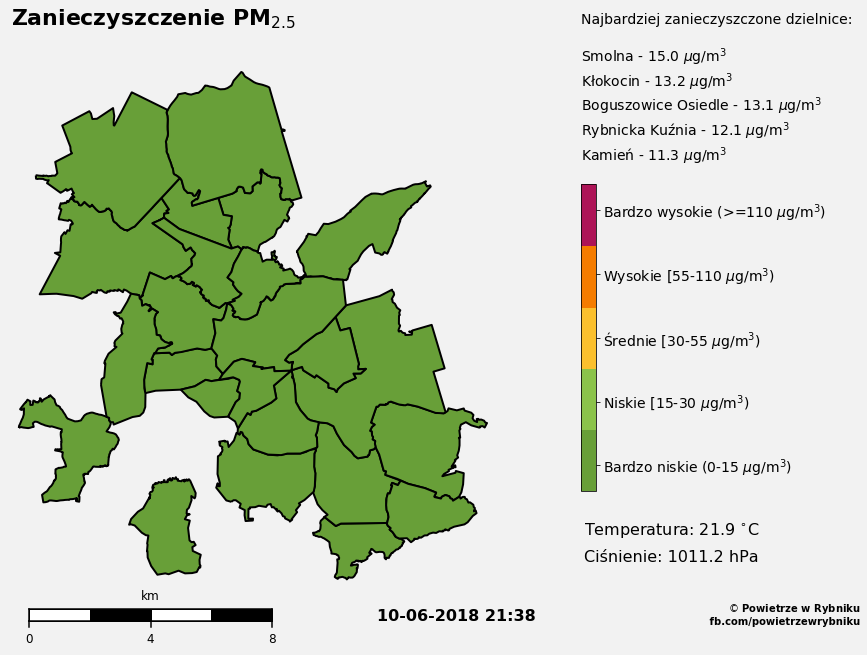

In [81]:
#Create a map with current measurements for PM2.5 Index


pm25_labels = ['Bardzo niskie (0-15 $\mu$g/m$^3$)',
 'Niskie [15-30 $\mu$g/m$^3$)',
 'Średnie [30-55 $\mu$g/m$^3$)',
 'Wysokie [55-110 $\mu$g/m$^3$)',
    'Bardzo wysokie (>=110 $\mu$g/m$^3$)']

for i, text in enumerate(pm25_labels):
    pm25_labels[i] = text.decode('utf-8')
    
from matplotlib import colors
cmap = colors.ListedColormap(['#689f38','#8bc34a','#fbc02d','#f57c00','#ad1457'])
bounds= [0,25,50,90,180,1000]
norm = colors.BoundaryNorm(bounds, cmap.N)


plt.clf()
fig = plt.figure()
ax = fig.add_subplot(111, facecolor='w', frame_on=False)
fig.patch.set_facecolor('#f2f2f2')
# use a blue colour ramp - we'll be converting it to a map using cmap()
#cmap = plt.get_cmap('RdYlGn_r')
# draw wards with grey outlines
df_map['patches'] = df_map['poly'].map(lambda x: PolygonPatch(x, ec='#000000', lw=2., alpha=1., zorder=4))
pc = PatchCollection(df_map['patches'], match_original=True)
# impose our colour map onto the patch collection
#norm = Normalize()
pc.set_facecolor(cmap(norm(df_map['currentMeasurements.pm25'].values)))
ax.add_collection(pc)


# Add a colour bar
cb = colorbar_index(ncolors=len(pm25_labels), cmap=cmap, shrink=0.5, labels=pm25_labels)
cb.ax.tick_params(labelsize=14)


# Show highest densities, in descending order
highest = '\n'.join(
    value[1] + " - " + str(round(value['currentMeasurements.pm25'],1)) + " $\mu$g/m$^3$" for _, value in df_map.sort_values(by='currentMeasurements.pm25', ascending=False)[:5].iterrows()).decode('utf-8')


highest = 'Najbardziej zanieczyszczone dzielnice:\n\n' + highest
# Subtraction is necessary for precise y coordinate alignment
details = cb.ax.text(
    0., 1.55,
    highest,
    ha='left', va='top',
    size=14,
    color='#000000')

# Show current date-hour
date = ax.text(
    1.10, 0.033,
    current_time,
    ha='right', va='bottom',  weight = 'bold',
    size=16,
    color='#000000',
transform=ax.transAxes)


# Show current temperature
tmpr = ax.text(
    1.2, 0.170,
    "Temperatura: %s $^{\circ}$C" %round(weather['currentMeasurements.temperature'].values[-1],1),
    ha='left', va='bottom', 
    size=16,
    color='#000000',
transform=ax.transAxes)

# Show current pressure
prsr = ax.text(
    1.2, 0.130,
    u"Ciśnienie: %s hPa" %round(weather['currentMeasurements.pressure'].values[-1]/100,1),
    ha='left', va='bottom', 
    size=16,
    color='#000000',
transform=ax.transAxes)


# Bin method, copyright and source data info
smallprint = cb.ax.text(
    1.78, 0.028,
    '$\copyright$ Powietrze w Rybniku\n fb.com/powietrzewrybniku'.decode('utf-8'),
    ha='right', va='bottom',
    size=10,
    weight = 'bold',
    color='#000000',
    transform=ax.transAxes)

# Draw a map scale
m.drawmapscale(
    coords[0] + 0.06, coords[1] - 0.01,
    coords[0], coords[1], 
    8.,
    barstyle='fancy', labelstyle='simple',
    fillcolor1='w', fillcolor2='#000000',
    fontcolor='#000000', fontsize=12,
    zorder=5)


plt.title("Zanieczyszczenie PM$_{2.5}$".decode('utf-8'), fontsize=22, loc='left', weight='bold')


#Save the file
plt.tight_layout()
plt.gcf().subplots_adjust(bottom=0.1)
fig.set_size_inches(12, 10)
plt.savefig('pictures/cur_pm25_%s.png'%current_time_to_file, dpi=200, alpha=True, bbox_inches='tight')
plt.show()

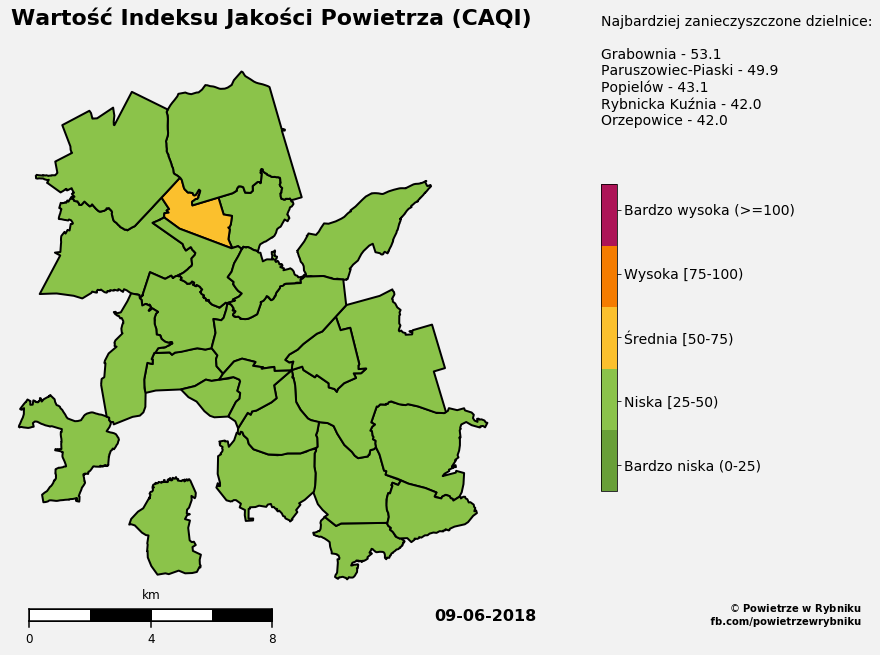

In [20]:
#Create a map with history measurements for Common Air Quality Index

cmap = colors.ListedColormap(['#689f38','#8bc34a','#fbc02d','#f57c00','#ad1457'])
bounds= [1,2,3,4,5,6]
norm = colors.BoundaryNorm(bounds, cmap.N)


plt.clf()
fig = plt.figure()
ax = fig.add_subplot(111, facecolor='w', frame_on=False)
fig.patch.set_facecolor('#f2f2f2')
# use a blue colour ramp - we'll be converting it to a map using cmap()
#cmap = plt.get_cmap('RdYlGn_r')
# draw wards with grey outlines
df_map['patches'] = df_map['poly'].map(lambda x: PolygonPatch(x, ec='#000000', lw=2., alpha=1., zorder=4))
pc = PatchCollection(df_map['patches'], match_original=True)
# impose our colour map onto the patch collection
#norm = Normalize()
pc.set_facecolor(cmap(norm(df_map['pollutionLevelhist'].values)))
ax.add_collection(pc)


# Add a colour bar
cb = colorbar_index(ncolors=len(caqi_labels), cmap=cmap, shrink=0.5, labels=caqi_labels)
cb.ax.tick_params(labelsize=14)


# Show highest densities, in descending order
highest = '\n'.join(
    value[1] + " - " + str(round(value['airQualityIndex'],1)) for _, value in df_map.sort_values(by='airQualityIndex', ascending=False)[:5].iterrows()).decode('utf-8')


highest = 'Najbardziej zanieczyszczone dzielnice:\n\n' + highest
# Subtraction is necessary for precise y coordinate alignment
details = cb.ax.text(
    0., 1.55,
    highest,
    ha='left', va='top',
    size=14,
    color='#000000')

# Show current date-hour
date = ax.text(
    1.10, 0.033,
    date_to_print,
    ha='right', va='bottom',  weight = 'bold',
    size=16,
    color='#000000',
transform=ax.transAxes)


# Bin method, copyright and source data info
smallprint = cb.ax.text(
    1.78, 0.028,
    '$\copyright$ Powietrze w Rybniku\n fb.com/powietrzewrybniku'.decode('utf-8'),
    ha='right', va='bottom',
    size=10,
    weight = 'bold',
    color='#000000',
    transform=ax.transAxes)


# Draw a map scale
m.drawmapscale(
    coords[0] + 0.06, coords[1] - 0.01,
    coords[0], coords[1], 
    8.,
    barstyle='fancy', labelstyle='simple',
    fillcolor1='w', fillcolor2='#000000',
    fontcolor='#000000', fontsize=12,
    zorder=5)


plt.title("Wartość Indeksu Jakości Powietrza (CAQI)".decode('utf-8'), fontsize=22, loc='left', weight='bold')


#Save the file
plt.tight_layout()
plt.gcf().subplots_adjust(bottom=0.1)
fig.set_size_inches(12, 10)
plt.savefig('pictures/caqi_%s.png'%date_to_file, dpi=200, alpha=True, bbox_inches='tight')
plt.show()

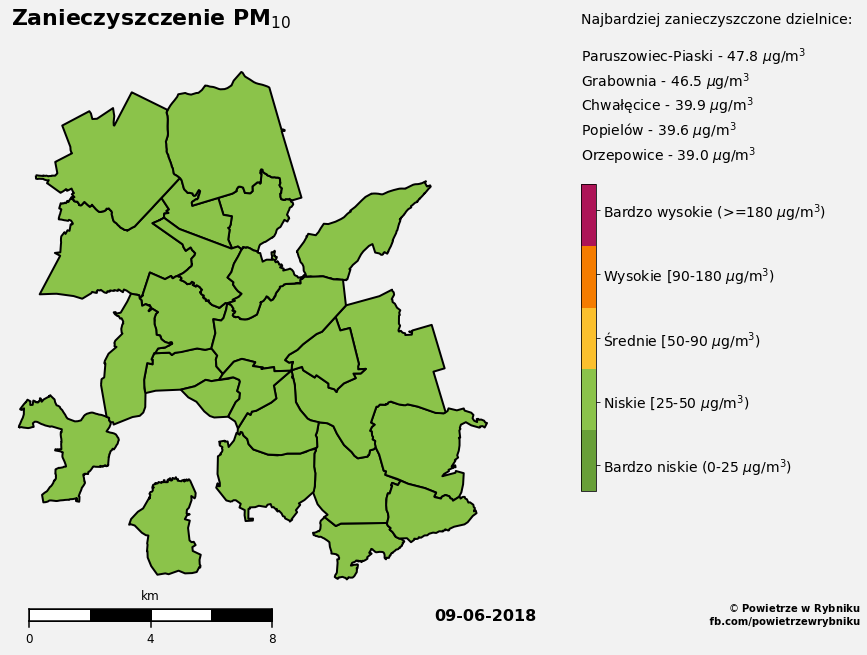

In [21]:
#Create a map with history measurements of PM10


cmap = colors.ListedColormap(['#689f38','#8bc34a','#fbc02d','#f57c00','#ad1457'])
bounds= [0,25,50,90,180,1000]
norm = colors.BoundaryNorm(bounds, cmap.N)


plt.clf()
fig = plt.figure()
ax = fig.add_subplot(111, facecolor='w', frame_on=False)
fig.patch.set_facecolor('#f2f2f2')
# use a blue colour ramp - we'll be converting it to a map using cmap()
#cmap = plt.get_cmap('RdYlGn_r')
# draw wards with grey outlines
df_map['patches'] = df_map['poly'].map(lambda x: PolygonPatch(x, ec='#000000', lw=2., alpha=1., zorder=4))
pc = PatchCollection(df_map['patches'], match_original=True)
# impose our colour map onto the patch collection
#norm = Normalize()
pc.set_facecolor(cmap(norm(df_map['pm10'].values)))
ax.add_collection(pc)


# Add a colour bar
cb = colorbar_index(ncolors=len(pm10_labels), cmap=cmap, shrink=0.5, labels=pm10_labels)
cb.ax.tick_params(labelsize=14)


# Show highest densities, in descending order
highest = '\n'.join(
    value[1] + " - " + str(round(value['pm10'],1)) + r" $\mu$g/m$^3$" for _, value in df_map.sort_values(by='pm10', ascending=False)[:5].iterrows()).decode('utf-8')


highest = 'Najbardziej zanieczyszczone dzielnice:\n\n' + highest

# Subtraction is necessary for precise y coordinate alignment
details = cb.ax.text(
    0., 1.55,
    highest,
    ha='left', va='top',
    size=14,
    color='#000000')

# Show current date-hour
date = ax.text(
    1.10, 0.033,
    date_to_print,
    ha='right', va='bottom',  weight = 'bold',
    size=16,
    color='#000000',
transform=ax.transAxes)


# Bin method, copyright and source data info
smallprint = cb.ax.text(
    1.78, 0.028,
    '$\copyright$ Powietrze w Rybniku\n fb.com/powietrzewrybniku'.decode('utf-8'),
    ha='right', va='bottom',
    size=10,
    weight = 'bold',
    color='#000000',
    transform=ax.transAxes)


# Draw a map scale
m.drawmapscale(
    coords[0] + 0.06, coords[1] - 0.01,
    coords[0], coords[1], 
    8.,
    barstyle='fancy', labelstyle='simple',
    fillcolor1='w', fillcolor2='#000000',
    fontcolor='#000000', fontsize=12,
    zorder=5)



plt.title("Zanieczyszczenie PM$_{10}$".decode('utf-8'), fontsize=22, loc='left', weight='bold')


#Save the file
plt.tight_layout()
plt.gcf().subplots_adjust(bottom=0.1)
fig.set_size_inches(12, 10)
plt.savefig('pictures/pm10_%s.png'%date_to_file, dpi=200, alpha=True, bbox_inches='tight')
plt.show()

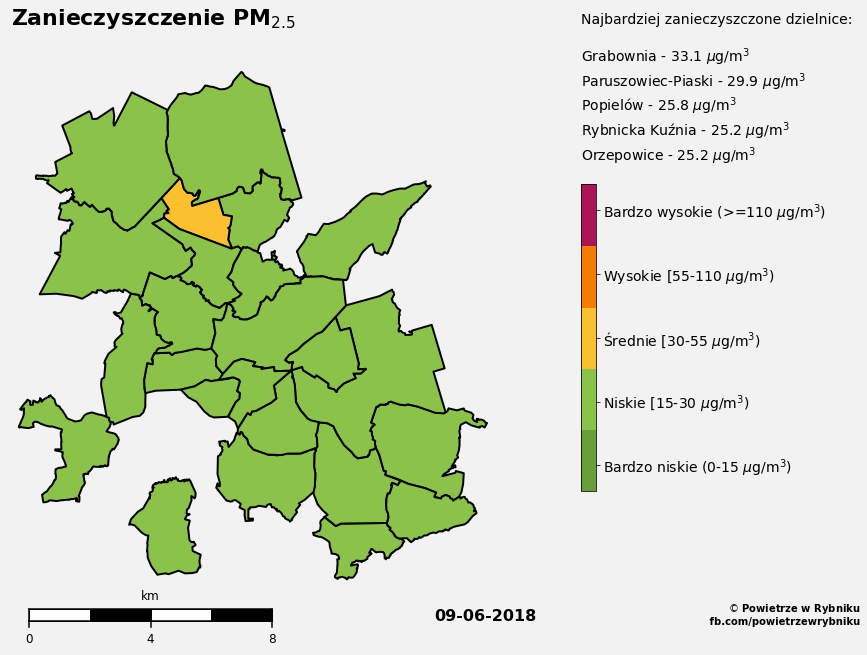

In [22]:
#Create a map with history measurements of PM2.5


pm25_labels = ['Bardzo niskie (0-15 $\mu$g/m$^3$)',
 'Niskie [15-30 $\mu$g/m$^3$)',
 'Średnie [30-55 $\mu$g/m$^3$)',
 'Wysokie [55-110 $\mu$g/m$^3$)',
    'Bardzo wysokie (>=110 $\mu$g/m$^3$)']

for i, text in enumerate(pm25_labels):
    pm25_labels[i] = text.decode('utf-8')
    
from matplotlib import colors
cmap = colors.ListedColormap(['#689f38','#8bc34a','#fbc02d','#f57c00','#ad1457'])
bounds= [0,15,30,55,110,1000]
norm = colors.BoundaryNorm(bounds, cmap.N)

plt.clf()
fig = plt.figure()
ax = fig.add_subplot(111, facecolor='w', frame_on=False)
fig.patch.set_facecolor('#f2f2f2')
# use a blue colour ramp - we'll be converting it to a map using cmap()
#cmap = plt.get_cmap('RdYlGn_r')
# draw wards with grey outlines
df_map['patches'] = df_map['poly'].map(lambda x: PolygonPatch(x, ec='#000000', lw=2., alpha=1., zorder=4))
pc = PatchCollection(df_map['patches'], match_original=True)
# impose our colour map onto the patch collection
#norm = Normalize()
pc.set_facecolor(cmap(norm(df_map['pm25'].values)))
ax.add_collection(pc)


# Add a colour bar
cb = colorbar_index(ncolors=len(pm25_labels), cmap=cmap, shrink=0.5, labels=pm25_labels)
cb.ax.tick_params(labelsize=14)


# Show highest densities, in descending order
highest = '\n'.join(
    value[1] + " - " + str(round(value['pm25'],1)) + r" $\mu$g/m$^3$" for _, value in df_map.sort_values(by='pm25', ascending=False)[:5].iterrows()).decode('utf-8')


highest = 'Najbardziej zanieczyszczone dzielnice:\n\n' + highest
# Subtraction is necessary for precise y coordinate alignment
details = cb.ax.text(
    0., 1.55,
    highest,
    ha='left', va='top',
    size=14,
    color='#000000')

# Show current date-hour
date = ax.text(
    1.10, 0.033,
    date_to_print,
    ha='right', va='bottom',  weight = 'bold',
    size=16,
    color='#000000',
transform=ax.transAxes)


# Bin method, copyright and source data info
smallprint = cb.ax.text(
    1.78, 0.028,
    '$\copyright$ Powietrze w Rybniku\n fb.com/powietrzewrybniku'.decode('utf-8'),
    ha='right', va='bottom',
    size=10,
    weight = 'bold',
    color='#000000',
    transform=ax.transAxes)


# Draw a map scale
m.drawmapscale(
    coords[0] + 0.06, coords[1] - 0.01,
    coords[0], coords[1], 
    8.,
    barstyle='fancy', labelstyle='simple',
    fillcolor1='w', fillcolor2='#000000',
    fontcolor='#000000', fontsize=12,
    zorder=5)


plt.title("Zanieczyszczenie PM$_{2.5}$".decode('utf-8'), fontsize=22, loc='left', weight='bold')


#Save the file
plt.tight_layout()
plt.gcf().subplots_adjust(bottom=0.1)
fig.set_size_inches(12, 10)
plt.savefig('pictures/pm25_%s.png'%date_to_file, dpi=200, alpha=True, bbox_inches='tight')
plt.show()

In [62]:
#Uploading files to Facebook page
graph = facebook.GraphAPI(access_token=token, version='2.6')
#if version 2.8 show error use 2.6

#Current measurements
graph.put_photo(image=open('pictures/cur_pm25_%s.png'%current_time_to_file, 'rb'), message='Zanieczyszczenie PM 2.5, %s'%current_time)
graph.put_photo(image=open('pictures/cur_pm10_%s.png'%current_time_to_file, 'rb'), message='Zanieczyszczenie PM 10, %s'%current_time)
graph.put_photo(image=open('pictures/cur_caqi_%s.png'%current_time_to_file, 'rb'), message='Indeks jakości powietrza, %s'%current_time)
graph.put_photo(image=open('pictures/weather_%s.png'%current_time_to_file, 'rb'), message='Powietrze w Rybniku w ostatnich 24 godzinach')


#Historical measurements
graph.put_photo(image=open('pictures/pm25_%s.png'%date_to_file, 'rb'), message='Zanieczyszczenie PM 2.5, %s'%date_to_print)
graph.put_photo(image=open('pictures/pm10_%s.png'%date_to_file, 'rb'), message='Zanieczyszczenie PM 10, %s'%date_to_print)
graph.put_photo(image=open('pictures/caqi_%s.png'%date_to_file, 'rb'), message='Indeks jakości powietrza, %s'%date_to_print)


{u'id': u'2219894958240515', u'post_id': u'2189147481315263_2219894958240515'}